In [24]:
#importing packages
import pandas as pd
from ucimlrepo import fetch_ucirepo 

#graph packages
import matplotlib.pyplot as plt
import seaborn as sns

#statistics
from scipy.stats import kendalltau
from category_encoders.binary import BinaryEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

#models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.svm import SVR 
from sklearn.ensemble import BaggingRegressor

## Data Ingestion

In [25]:
# fetch dataset 
student_performance = fetch_ucirepo(id=320) 
  
# data (as pandas dataframes) 
X = student_performance.data.features 
y = student_performance.data.targets 

y_subset = y[['G1', 'G2']]
X = pd.concat([X, y_subset], axis=1)

y = y.drop(['G1', 'G2'], axis=1)

# variable information 
var_info = student_performance.variables
# print(student_performance.variables) 

In [26]:
y

,G3
0,11
1,11
2,12
3,14
4,13
...,...
644,10
645,16
646,9
647,10


The dataset seems to have no missing values. From the table above we can also observe that there are 8 categorical variables

## EDA

In [27]:
X["school"].value_counts()

GP    423
MS    226
Name: school, dtype: int64

In [28]:
X["sex"].value_counts()

F    383
M    266
Name: sex, dtype: int64

In [29]:
def print_val_counts():
    list_vals = ["G1", "G2", "G3"]
    for i in range(len(var_info.name)):
        if var_info.name[i] not in list_vals and var_info.type[i] != 'integer':
            print(X[f"{var_info.name[i]}"].value_counts())

print_val_counts()

GP    423
MS    226
Name: school, dtype: int64
F    383
M    266
Name: sex, dtype: int64
17    179
16    177
18    140
15    112
19     32
20      6
21      2
22      1
Name: age, dtype: int64
U    452
R    197
Name: address, dtype: int64
GT3    457
LE3    192
Name: famsize, dtype: int64
T    569
A     80
Name: Pstatus, dtype: int64
2    186
4    175
1    143
3    139
0      6
Name: Medu, dtype: int64
2    209
1    174
3    131
4    128
0      7
Name: Fedu, dtype: int64
other       258
services    136
at_home     135
teacher      72
health       48
Name: Mjob, dtype: int64
other       367
services    181
at_home      42
teacher      36
health       23
Name: Fjob, dtype: int64
course        285
home          149
reputation    143
other          72
Name: reason, dtype: int64
mother    455
father    153
other      41
Name: guardian, dtype: int64
1    366
2    213
3     54
4     16
Name: traveltime, dtype: int64
2    305
1    212
3     97
4     35
Name: studytime, dtype: int64
0    549
1  

From the above information, we can see that a lot of the variables have already been encoded. The decisions to make at this stage would be as follows:  
1. Do we encode the categories 'Mjob', 'Fjob' and 'reason' ? Since we are predicting G3 which is a numerical value, it will help the machine learning model in better understanding the relationship between those variables
2. Can we drop the columns 'school' and 'sex' ? The reason to drop these two would be the added bias as the grade should not depend on either factors too strongly. 

In [30]:
y

,G3
0,11
1,11
2,12
3,14
4,13
...,...
644,10
645,16
646,9
647,10


In [31]:
#creating a temporary dataframe by merging the features dataframe with G3
temp_data = pd.merge(X, y[["G3"]], left_index=True, right_index=True)
temp_data

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,MS,F,19,R,GT3,T,2,3,services,other,...,5,4,2,1,2,5,4,10,11,10
645,MS,F,18,U,LE3,T,3,1,teacher,services,...,4,3,4,1,1,1,4,15,15,16
646,MS,F,18,U,GT3,T,1,1,other,other,...,1,1,1,1,1,5,6,11,12,9
647,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,6,10,10,10


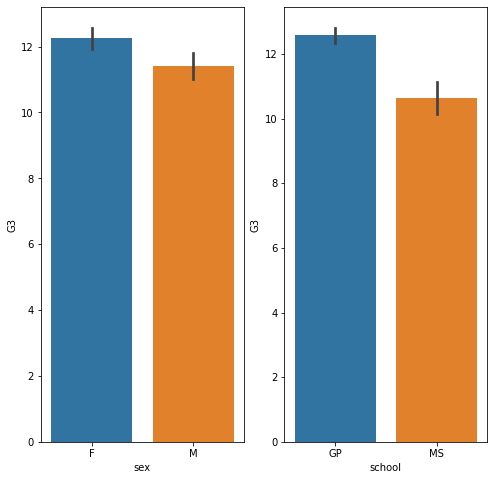

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(8, 8))
sns.barplot(x='sex', y='G3', data=temp_data, ax=ax[0])
sns.barplot(x='school', y='G3', data=temp_data, ax=ax[1])
plt.show()

From here we can see that in terms of the 'Sex' column, the 'F' category has a slightly higher grade in G3 compared to 'M'. In terms of the 'school' column the 'GP' school is much better performing with a higher G3 score. Given the fact that there are changes in grades based on the categorical values, I have decided to include both 'sex' and 'school' though I may change it later on based on the model performance.

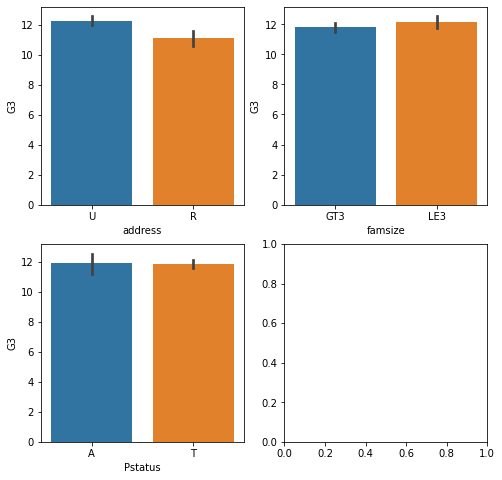

In [33]:
#next we need to decide on whether to include variables such as 'address', 'famSize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob'
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
sns.barplot(x='address', y='G3', data=temp_data, ax=ax[0, 0])
sns.barplot(x='famsize', y='G3', data=temp_data, ax=ax[0, 1])
sns.barplot(x='Pstatus', y='G3', data=temp_data, ax=ax[1, 0])
plt.show()

In [34]:
#further confirm if Pstatus affects G3 by checking for its coefficient
temp_data['Pstatus'] = temp_data['Pstatus'].replace({'A': 1, 'T': 0})
print(temp_data['Pstatus'].corr(temp_data['G3']))

0.000753925049818372


I plotted barplots to check for the relationship between a few more categorical variables. From the plots the weakest relation I could observe was between 'Pstatus' and 'G3' and a further calculation of correlation coeeficient confirmed that there is very weak correlation and so we can drop 'Pstatus'

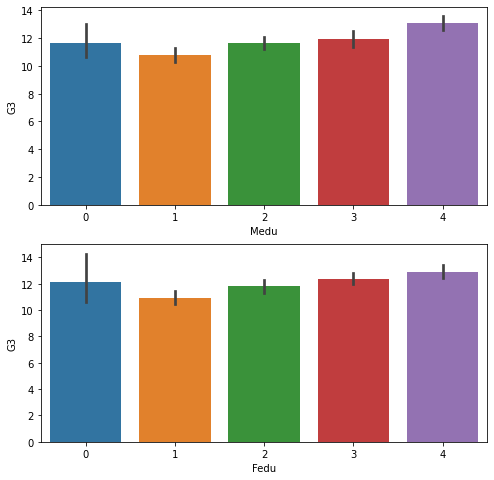

In [35]:
fig, ax = plt.subplots(2, figsize=(8, 8))
sns.barplot(x='Medu', y='G3', data=temp_data, ax=ax[0])
sns.barplot(x='Fedu', y='G3', data=temp_data, ax=ax[1])
plt.show()

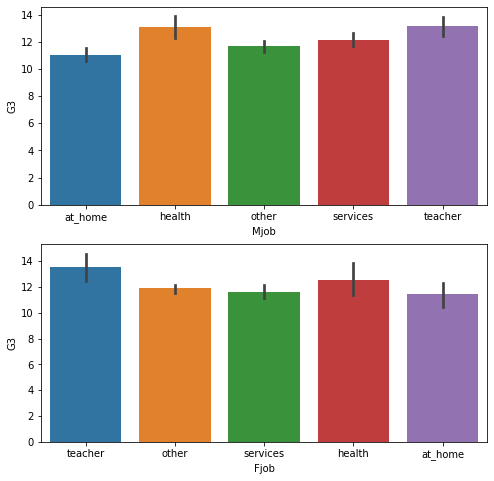

In [36]:
fig, ax = plt.subplots(2, figsize=(8, 8))
sns.barplot(x='Mjob', y='G3', data=temp_data, ax=ax[0])
sns.barplot(x='Fjob', y='G3', data=temp_data, ax=ax[1])
plt.show()

From the two sets of graphs , it can be observed that there is a significant correlation between the occupation of the Mother and Father and the G3 score. 

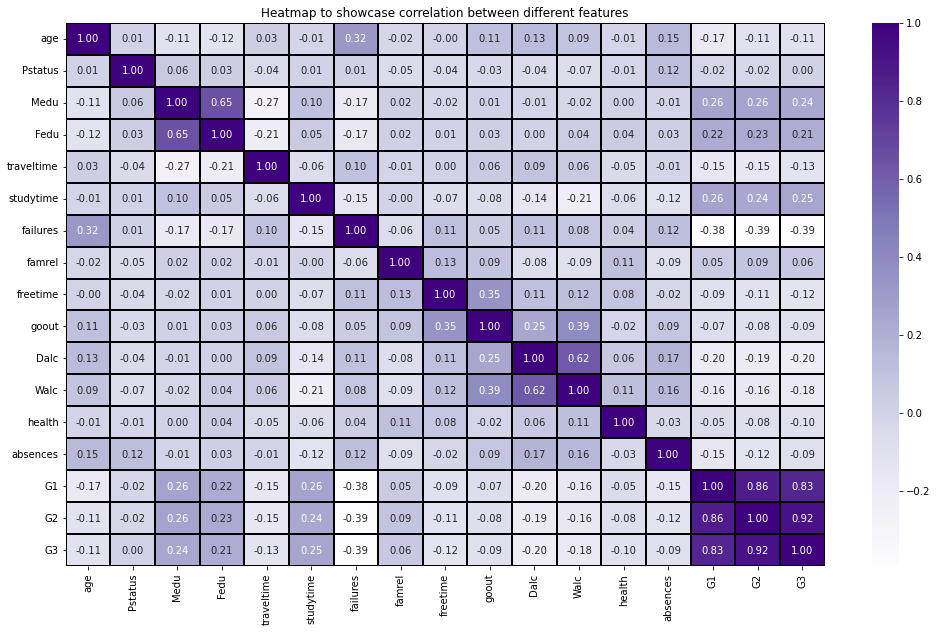

In [37]:
#correlation graph 
plt.figure(figsize=(17, 10))
sns.heatmap(temp_data.corr(), cmap="Purples", linewidths=2, linecolor='black', annot=True, fmt=".2f")
plt.title("Heatmap to showcase correlation between different features")
plt.show()

The only even slightly correlated features to G3 are 'school', 'Medu', 'Fedu' and 'studytime'

## Data Pre-Processing

In this section we are going to be pre-processing the data in order to make sure the model's predictions are accurate

In [38]:
#encoding 
X['sex'] = X['sex'].replace({'F':1, 'M':0})
X['Pstatus'] = X['Pstatus'].replace({'A': 1, 'T': 0})

#one-hot encoding of Mjob and Fjob
one_hot_mjob = pd.get_dummies(X['Mjob'], prefix='Mjob')
X = X.drop('Mjob',axis = 1)
X = X.join(one_hot_mjob)

one_hot_fjob = pd.get_dummies(X['Fjob'], prefix='Fjob')
X = X.drop('Fjob',axis = 1)
X = X.join(one_hot_fjob)

#guardian
one_hot_guardian = pd.get_dummies(X['guardian'], prefix='guardian')
X = X.drop('guardian',axis = 1)
X = X.join(one_hot_guardian)

#school
X['school'] = X['school'].replace({'GP':1, 'MS':0})

#address
X['address'] = X['address'].replace({'U':1, 'R':0})

#famsize
X['famsize'] = X['famsize'].replace({'LE3':1, 'GT3':0})

#reason 
one_hot_reason = pd.get_dummies(X['reason'], prefix='reason')
X = X.drop('reason',axis = 1)
X = X.join(one_hot_reason)

#converting all binary columns at once
mapping = {'yes': 1, 'no': 0}
X = X.replace(mapping)

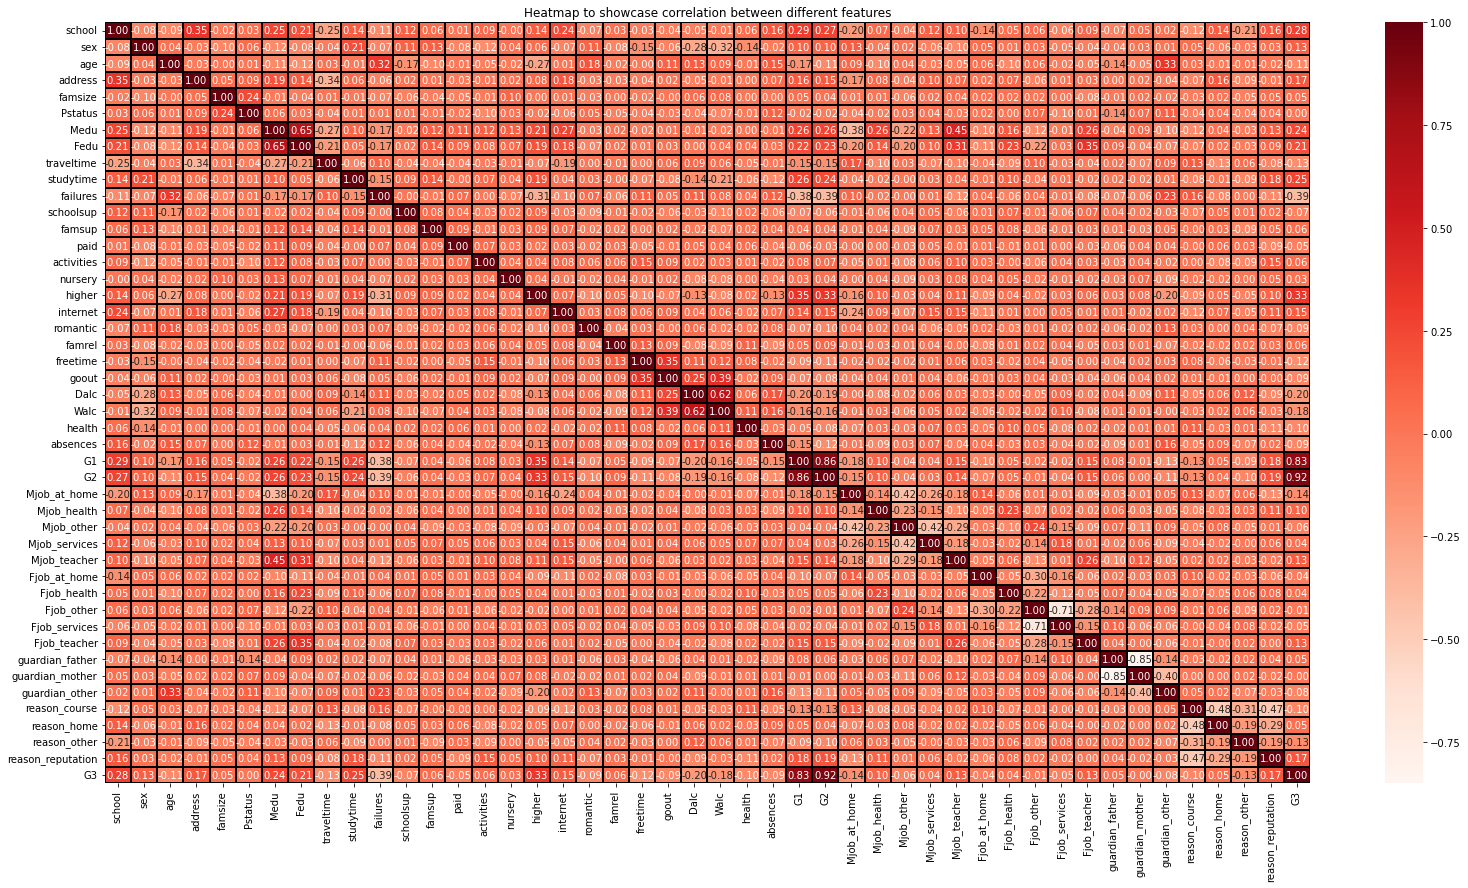

In [39]:
#correlation graph 
temp_X = pd.merge(X, y[["G3"]], left_index=True, right_index=True)

plt.figure(figsize=(27, 14))
sns.heatmap(temp_X.corr(), cmap="Reds", linewidths=2, linecolor='black', annot=True, fmt=".2f")
plt.title("Heatmap to showcase correlation between different features")
plt.show()

## Feature Selection

The data analysis in the previous part gave us a good idea of the correlation of the features with the target variable. The only feature that stood out with having the weakest relation was 'Pstatus'
On some features an in-depth analysis was not carried out, instead we tried to observe their correlation to G3 through the correlation graph plotted

In [40]:
X = X.drop('Pstatus', axis=1)
X = X.drop('failures', axis=1)
X = X.drop('Dalc', axis=1)
X = X.drop('reason_other', axis=1)

## Scaling/Normalization 

In [41]:
X.describe()

,school,sex,age,address,famsize,Medu,Fedu,traveltime,studytime,schoolsup,...,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,guardian_father,guardian_mother,guardian_other,reason_course,reason_home,reason_reputation
count,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,...,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000
mean,0.651772,0.590139,16.744222,0.696456,0.295840,2.514638,2.306626,1.568567,1.930663,0.104777,...,0.035439,0.565485,0.278891,0.055470,0.235747,0.701079,0.063174,0.439137,0.229584,0.220339
std,0.476776,0.492187,1.218138,0.460143,0.456771,1.134552,1.099931,0.748660,0.829510,0.306502,...,0.185030,0.496075,0.448799,0.229072,0.424792,0.458138,0.243464,0.496665,0.420890,0.414795
min,0.000000,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,16.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,17.000000,1.000000,0.000000,2.000000,2.000000,1.000000,2.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,18.000000,1.000000,1.000000,4.000000,3.000000,2.000000,2.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,22.000000,1.000000,1.000000,4.000000,4.000000,4.000000,4.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


No scaling needed since all the values are encoded or categorical 

## Model Training

In [42]:
y

,G3
0,11
1,11
2,12
3,14
4,13
...,...
644,10
645,16
646,9
647,10


In [43]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

In [44]:
#linear regression 
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predictions
y_pred = linear_model.predict(X_test)

# Evaluate performance
linear_r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # RMSE
mae = mean_absolute_error(y_test, y_pred)

In [45]:
#Decision tree
clf = DecisionTreeRegressor()

# Train Decision Tree regressor
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
clf_r2 = r2_score(y_test, y_pred)

In [46]:
#Random Forest
rfr_model = RandomForestRegressor(n_estimators=100, random_state=42)
rfr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rfr_model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
rfr_r2 = r2_score(y_test, y_pred)

/var/folders/cz/sb2kbc4925qcf91d0v0pj8ch0000gn/T/ipykernel_17283/2381898799.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr_model.fit(X_train, y_train)


In [47]:
# Create and fit the XGBoost regressor model
xg_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xg_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xg_model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
xg_r2 = r2_score(y_test, y_pred)

In [48]:
# Create and fit the LightGBM regressor model
light_model = lgb.LGBMRegressor(random_state=42)
light_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = light_model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
light_r2 = r2_score(y_test, y_pred)

In [49]:
# Create and fit the CatBoost regressor model
cat_model = CatBoostRegressor(random_state=42, silent=True)
cat_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = cat_model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
cat_r2 = r2_score(y_test, y_pred)

In [50]:
#SVM 
# create an SVR model with a linear kernel 
svr = SVR(kernel='linear') 
  
# train the model on the data 
svr.fit(X_train, y_train) 
  
# make predictions on the data 
y_pred = svr.predict(X_test) 

mse = mean_squared_error(y_test, y_pred)
svr_r2 = r2_score(y_test, y_pred)

/Users/shariqmalik/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


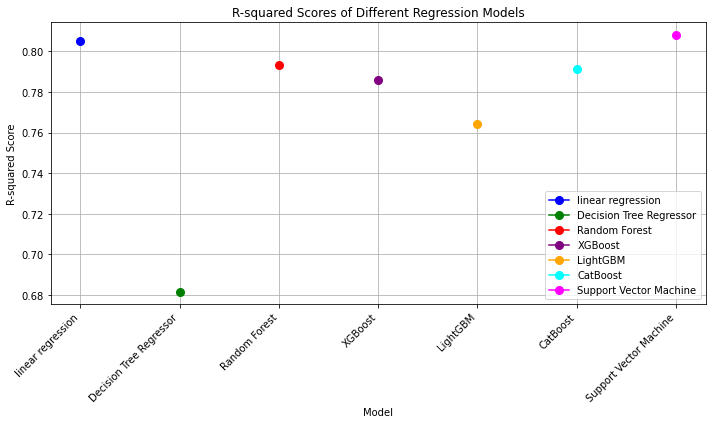

In [51]:
#from the base models, we can pick the top 2 best performing models based on their r2 value 
r2_scores = [linear_r2, clf_r2, rfr_r2, xg_r2, light_r2, cat_r2, svr_r2]
model_names = ["linear regression", "Decision Tree Regressor", "Random Forest", "XGBoost", "LightGBM", "CatBoost", "Support Vector Machine"]

colors = ['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'magenta']

# Plot R-squared scores
plt.figure(figsize=(10, 6))
for i, model_name in enumerate(model_names):
    plt.plot([model_name], [r2_scores[i]], marker='o', markersize=8, color=colors[i], label=model_name)

# Add labels and title
plt.xlabel('Model')
plt.ylabel('R-squared Score')
plt.title('R-squared Scores of Different Regression Models')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Show plot
plt.show()

From the above graph it can be observed that the best performing models are:
1. Linear Regression model 
2. Random Forest
3. SVM
4. CatBoost  
For the next section, we are going to try to fine tune the hyper parameters to see how much the performance of the three models can be improved 

## HyperParameter Fine-Tuning

### CatBoost Tuning

In [52]:
catboost_grid = {
    'learning_rate': [0.03, 0.06],
    'depth':[3, 6, 9],
    'l2_leaf_reg': [2, 3, 4],
    'boosting_type': ['Ordered', 'Plain']
}

grid_search = GridSearchCV(cat_model, catboost_grid, cv=3, scoring="r2")
grid_result = grid_search.fit(X_train, y_train)

best_params = grid_result.best_params_
best_score = grid_result.best_score_

In [53]:
print(cat_r2)

0.7913561291065663


In [54]:
print(best_score)

0.8235588290251622


Improvement of 2% was noticed. A very small improvement

### Random Forest Tuning

In [55]:
rfr_model.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [56]:
rfr_grid = { 
    'n_estimators': [25, 50, 100, 150], 
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [3, 6, 9], 
    'max_leaf_nodes': [3, 6, 9], 
}

grid_search_rfr = GridSearchCV(rfr_model, rfr_grid, cv=5, scoring="r2")
grid_result_rfr = grid_search_rfr.fit(X_train, y_train.values.ravel())

best_params_rfr = grid_result_rfr.best_params_
best_score_rfr = grid_result_rfr.best_score_

In [57]:
print(rfr_r2)
print(best_score_rfr)

0.7934882023595281
0.8288278605812824


### SVM Tuning

In [58]:
svm_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001]
             }

grid_search_svr = GridSearchCV(svr, svm_grid, cv=2, scoring="r2")
grid_result_svr = grid_search_svr.fit(X_train, y_train.values.ravel())

best_params_svr = grid_result_svr.best_params_
best_score_svr = grid_result_svr.best_score_

In [59]:
print(best_score_svr)

0.8374312818108074


In [1]:
# make the html file 
from nbconvert import HTMLExporter
import nbformat

notebook_file = 'student_perf_model.ipynb'

# Read the notebook
with open(notebook_file, 'r', encoding='utf-8') as notebook_file_content:
    notebook_content = nbformat.read(notebook_file_content, as_version=4)

# Create an HTMLExporter instance
html_exporter = HTMLExporter()

# Converting notebook to HTML file
(html_output, resources) = html_exporter.from_notebook_node(notebook_content)

html_output_file = 'student_perf_model.html'

with open(html_output_file, 'w', encoding='utf-8') as html_file:
    html_file.write(html_output)

#confirmation message
print(f'The notebook has been successfully converted to HTML. Output saved to {html_output_file}.')

The notebook has been successfully converted to HTML. Output saved to student_perf_model.html.
